In [1]:
import os

gpus = [0]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf 
import tensorflow.keras as keras
import numpy as np 
#from oe_acute import MNE
import pickle
import sys
import random
#from AE import MDSAE as ae
#from network_visualisation import plot_these_aud_weights
#import network_visualisation
#import quantify_aud_strfs
import matplotlib.pyplot as plt

In [3]:
bird = 'B1240'
d = 256

### Allocate GPUs

In [4]:
gpus = [0] # Here I set CUDA to only see one GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use
if len(gpus) < 1:
    num_gpus = 1 

In [5]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print( [x.name for x in local_device_protos if x.device_type == 'GPU'] )

['/device:GPU:0']


### Model function

In [6]:
class Temporal_Specgram_CNN_Model(keras.Model):
    def __init__(self, **kwargs):
        super(Temporal_Specgram_CNN_Model, self).__init__()
        self.__dict__.update(kwargs)
        self.enc_1=keras.Sequential([
            keras.Input(shape=(32, 32, 1)),
#             keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu",),
            keras.layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation="relu",),
            tf.keras.layers.Flatten(),
            
            
        ])
        self.enc_dropout=tf.keras.layers.Dropout(0.5)
        self.enc_2=tf.keras.layers.Dense(units=d,activation='sigmoid', kernel_regularizer=keras.regularizers.L1(10**-3.5),)
        self.dec_recon=keras.Sequential([
            tf.keras.layers.Dense(units=16 * 16 * 256, activation="relu", kernel_regularizer=keras.regularizers.L1(10**-3.5)),
            tf.keras.layers.Reshape(target_shape=(16, 16, 256)),
#             tf.keras.layers.Conv2DTfranspose(
#                 filters=16, kernel_size=2, strides=(2, 2),  activation="relu", kernel_regularizer=keras.regularizers.L1(10**-3.5), 
#             ),
            tf.keras.layers.Conv2DTranspose(
                filters=8, kernel_size=2, strides=(2, 2), activation="relu", kernel_regularizer=keras.regularizers.L1(10**-3.5)
            ),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=1, strides=(1, 1), kernel_regularizer=keras.regularizers.L1(10**-3.5)
            ),
        ])
        self.dec_pred=keras.Sequential([tf.keras.layers.Dense(units=32, kernel_regularizer=keras.regularizers.L1(10**-3.5))])
        self.recon_losses=[]
        self.pred_losses=[]
    @tf.function
    def get_loss(self, x_t, y_t):
        #print(x_t)#.shape
        x_hat, y_hat = self(tf.expand_dims(x_t, -1))
        pred_losses=tf.reduce_mean(tf.square(y_t - y_hat))
        
        recon_losses=tf.reduce_mean(tf.square(x_t - tf.squeeze(x_hat, -1)))

        
        return pred_losses,recon_losses

    @tf.function
    def get_gradients(self, x_t, y_t):
        with tf.GradientTape() as tape:
            pred_losses,recon_losses = self.get_loss(x_t, y_t)
            #tf.print(pred_losses, recon_losses)
            loss=pred_losses+0.5*recon_losses
            
        return loss, tape.gradient(loss, self.enc_1.trainable_variables+self.enc_2.trainable_variables+self.dec_recon.trainable_variables+self.dec_pred.trainable_variables)
    
    @tf.function
    def train_model(self, X_train, y_train):
        loss, gradients = self.get_gradients(X_train, y_train)
        self.optimizer.apply_gradients(zip(gradients, self.enc_1.trainable_variables+self.enc_2.trainable_variables+self.dec_recon.trainable_variables+self.dec_pred.trainable_variables))
        return loss

    @tf.function
    def compute_test_loss(self, X_test, y_test):
        x_hat, y_hat = self.predict(tf.expand_dims(X_test, -1))
        pred_losses=tf.reduce_mean(tf.square(y_test - y_hat))
        
        recon_losses=tf.reduce_mean(tf.square(X_test - tf.squeeze(x_hat, -1)))

        
        return pred_losses,recon_losses


    def call(self, input):
        latent=self.enc_1(input)
        latent=self.enc_dropout(latent, training=True)
        latent=self.enc_2(latent)
        return self.dec_recon(latent), self.dec_pred(latent)

    def predict(self, input):
        latent=self.enc_1(input)
        latent=self.enc_dropout(latent, training=False)
        latent=self.enc_2(latent)
        return self.dec_recon(latent), self.dec_pred(latent)


In [7]:
#model.enc.

In [8]:
#x_t, y_t = train_batch[0], train_batch[1]

In [9]:
#pred_losses,recon_losses=model.get_loss(x_t, y_t)

In [10]:
#pred_losses

### Load data

In [11]:
def extract_spec_data(x_path, y_path, random_seed=None, global_normalize=False):
#def extract_spec_data(x_path1, x_path2, x_path3, x_path4, x_path5, y_path, random_seed=None):
#def extract_spec_data(x_path1, x_path2, y_path, random_seed=None):
    all_curr=np.load(x_path,allow_pickle=True)
    #all_next=np.load(y_path,allow_pickle=True)
    #all_curr1 = pickle.load(open(x_path1, 'rb'))
    #all_curr2 = pickle.load(open(x_path2, 'rb'))
    #all_curr3 = pickle.load(open(x_path3, 'rb'))
    #all_curr4 = pickle.load(open(x_path4, 'rb'))
    #all_curr5 = pickle.load(open(x_path5, 'rb'))

    all_next=np.load(y_path,allow_pickle=True)
    
    x_array = all_curr
    #x_array = np.concatenate((all_curr1, all_curr2, all_curr3, all_curr4, all_curr5), axis=0)
    #x_array = np.concatenate((all_curr1, all_curr2), axis=0)
    y_array = all_next

    #x_array = np.vstack(all_curr)
    #y_array = np.vstack(all_next)

    if random_seed is None:
        rand_idx=np.arange(0, np.shape(x_array)[0])
    else:
        np.random.seed(random_seed)
        rand_idx=np.random.choice(range(np.shape(x_array)[0]), size=np.shape(x_array)[0],replace=False)
    
    split_train_idx, split_val_idx = rand_idx[np.shape(x_array)[0]//10:],rand_idx[:np.shape(x_array)[0]//10] 
    x_train, x_val=np.asarray(x_array)[split_train_idx], np.asarray(x_array)[split_val_idx]
    y_train, y_val=np.asarray(y_array)[split_train_idx],np.asarray(y_array)[split_val_idx]
    
    #if global_normalize:
    #    x_train=x_train/x_train.max()
    #    y_train=y_train/y_train.max()
    #    x_val=x_val/x_val.max()
    #    y_val=y_val/y_val.max()
    return x_train,y_train,x_val,y_val

In [12]:
segs_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_32.pkl'.format(bird, bird)     ###change
#segs_path2 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_{}_32_part2.pkl'.format(bird, bird)     ###change
#segs_path3 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_{}_32_part3.pkl'.format(bird, bird)     ###change
#segs_path4 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_{}_32_part4.pkl'.format(bird, bird)     ###change
#segs_path5 = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_{}_32_part5.pkl'.format(bird, bird)     ###change
next_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/next_list_32.pkl'.format(bird, bird)            ###change

In [13]:
#x_train,y_train,x_val,y_val = extract_spec_data(segs_path, next_path, random_seed=0,global_normalize=True)
x_train1,y_train1,x_val1,y_val1 = extract_spec_data(segs_path,next_path,random_seed=0)

In [14]:
x_train = x_train1[:, :32, :]
x_val = x_val1[:, :32, :]
y_train = y_train1[:, :32]
y_val = y_val1[:, :32]

In [15]:
np.shape(x_train), np.shape(x_val), np.shape(y_train)

((51357, 32, 32), (5706, 32, 32), (51357, 32))

### Training network

Epoch 0, Train-Loss 0.040806520730257034
Epoch 1, Train-Loss 0.04200191795825958
Epoch 2, Train-Loss 0.028570037335157394
Epoch 3, Train-Loss 0.020732935518026352
Epoch 4, Train-Loss 0.03017290309071541
Epoch 5, Train-Loss 0.024003680795431137
Epoch 6, Train-Loss 0.019875073805451393
Epoch 7, Train-Loss 0.016067752614617348
Epoch 8, Train-Loss 0.019748441874980927
Epoch 9, Train-Loss 0.011057842522859573
Epoch 10, Train-Loss 0.009344208985567093
Epoch 11, Train-Loss 0.011613276787102222
Epoch 12, Train-Loss 0.009030554443597794
Epoch 13, Train-Loss 0.01164373941719532
Epoch 14, Train-Loss 0.008892755024135113
Epoch 15, Train-Loss 0.010286339558660984
Epoch 16, Train-Loss 0.00837254524230957
Epoch 17, Train-Loss 0.007879850454628468
Epoch 18, Train-Loss 0.006967806722968817
Epoch 19, Train-Loss 0.007603387348353863
Epoch 20, Train-Loss 0.0067965202033519745
Epoch 21, Train-Loss 0.007707543671131134
Epoch 22, Train-Loss 0.007261364720761776
Epoch 23, Train-Loss 0.007869957946240902
Epoch

Epoch 193, Train-Loss 0.0034488514065742493
Epoch 194, Train-Loss 0.0029762848280370235
Epoch 195, Train-Loss 0.0028624506667256355
Epoch 196, Train-Loss 0.002692459849640727
Epoch 197, Train-Loss 0.003600427880883217
Epoch 198, Train-Loss 0.0028406628407537937
Epoch 199, Train-Loss 0.003253828501328826
Epoch 200, Train-Loss 0.0033348039723932743
Epoch 201, Train-Loss 0.0028639063239097595
Epoch 202, Train-Loss 0.0035345484502613544
Epoch 203, Train-Loss 0.003287028055638075
Epoch 204, Train-Loss 0.0031976266764104366
Epoch 205, Train-Loss 0.0033937515690922737
Epoch 206, Train-Loss 0.003808123990893364
Epoch 207, Train-Loss 0.0032454945612698793
Epoch 208, Train-Loss 0.002854736289009452
Epoch 209, Train-Loss 0.0031533942092210054
Epoch 210, Train-Loss 0.002855804516002536
Epoch 211, Train-Loss 0.0034067188389599323
Epoch 212, Train-Loss 0.0031382089946419
Epoch 213, Train-Loss 0.0033327583223581314
Epoch 214, Train-Loss 0.0032034488394856453
Epoch 215, Train-Loss 0.003670294769108295

Epoch 382, Train-Loss 0.0025423411279916763
Epoch 383, Train-Loss 0.0026308693923056126
Epoch 384, Train-Loss 0.0022720899432897568
Epoch 385, Train-Loss 0.002573352074250579
Epoch 386, Train-Loss 0.0022517754696309566
Epoch 387, Train-Loss 0.0023414178285747766
Epoch 388, Train-Loss 0.002599644009023905
Epoch 389, Train-Loss 0.002408759668469429
Epoch 390, Train-Loss 0.0023620440624654293
Epoch 391, Train-Loss 0.0024382686242461205
Epoch 392, Train-Loss 0.00253239250741899
Epoch 393, Train-Loss 0.0026353541761636734
Epoch 394, Train-Loss 0.002531664911657572
Epoch 395, Train-Loss 0.002752631902694702
Epoch 396, Train-Loss 0.0022269897162914276
Epoch 397, Train-Loss 0.002100476296618581
Epoch 398, Train-Loss 0.002462774980813265
Epoch 399, Train-Loss 0.002560768276453018
Epoch 400, Train-Loss 0.0026526423171162605
Epoch 401, Train-Loss 0.002411983907222748
Epoch 402, Train-Loss 0.0027821867261081934
Epoch 403, Train-Loss 0.002499461406841874
Epoch 404, Train-Loss 0.002489402424544096
E

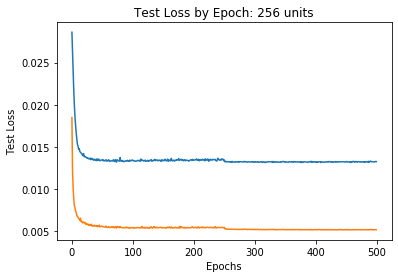

In [16]:
train_dset = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_dset = train_dset.shuffle(buffer_size=x_train.shape[0]+256).batch(64)
test_losses = []

optimizer = tf.optimizers.Adam(1e-3)
model = Temporal_Specgram_CNN_Model(optimizer=optimizer)
x_val, y_val = x_val.astype(np.float32), y_val.astype(np.float32)
with tf.device('/device:gpu:0'):
#     tf.print('Training Fold {}'.format(index))
    #model.load_weights('./temporal_specgram_weights/initial')
    for epoch in range(500):
        if epoch>250:
            model.optimizer.learning_rate=2e-4
        for step, train_batch in enumerate(train_dset):
            train_loss = model.train_model(train_batch[0], train_batch[1])

        tf.print('Epoch {}, Train-Loss {}'.format(epoch, train_loss), output_stream=sys.stdout)
        test_losses.append(model.compute_test_loss(x_val, y_val))
        
    plt.plot(test_losses)
    plt.xlabel('Epochs')
    plt.ylabel('Test Loss')
    plt.title('Test Loss by Epoch: {} units'.format(256))
    #plt.savefig('mnt/cube/srrudrar/temporal_model/loss_plots/{}units_loss.png'.format(256))

In [17]:
with tf.device('/device:gpu:3'):
    #model.save_weights('/mnt/cube/srrudrar/temporal_model/temporal_model_weights/temp_256_l1_3_5_500epoch_64batch.h5')
    #predicted = model.full_model(x_val)
    enc_train1 = model.enc_2(model.enc_dropout(model.enc_1(x_train[:15000,:,:][:,:,:,np.newaxis])))
    enc_train2 = model.enc_2(model.enc_dropout(model.enc_1(x_train[15000:30000,:,:][:,:,:,np.newaxis])))
    enc_train3 = model.enc_2(model.enc_dropout(model.enc_1(x_train[30000:,:,:][:,:,:,np.newaxis])))
    #enc_train4 = model.enc_2(model.enc_dropout(model.enc_1(x_train[45000:60000,:,:][:,:,:,np.newaxis])))
    #enc_train5 = model.enc_2(model.enc_dropout(model.enc_1(x_train[60000:80000,:,:][:,:,:,np.newaxis])))
    #enc_train6 = model.enc_2(model.enc_dropout(model.enc_1(x_train[80000:,:,:][:,:,:,np.newaxis])))
    enc_val = model.enc_2(model.enc_dropout(model.enc_1(x_val[:,:,:,np.newaxis])))
    #tf.print(predicted.shape)
    tf.print(enc_train1.shape)
    tf.print(enc_train2.shape)
    tf.print(enc_train3.shape)
    tf.print(enc_val.shape)

ResourceExhaustedError: OOM when allocating tensor with shape[21357,64,30,30] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [29]:
pred_test = np.vstack([model.dec_pred(enc_val)])

In [25]:
pred_train = model.dec_pred(enc_train)

In [24]:
enc_train = np.vstack([enc_train1, enc_train2, enc_train3])
enc_val = np.vstack([enc_val])

enc_train_reshape = np.reshape(enc_train, (len(enc_train),8,4))

In [26]:
np.shape(enc_train), np.shape(x_train), np.shape(enc_val), np.shape(x_val)

((51357, 32), (51357, 32, 32), (5706, 32), (5706, 32, 32))

In [30]:
np.shape(pred_test), np.shape(y_val)

((5706, 32), (5706, 32))

Text(0.5, 1.05, 'Mel Spectrogram')

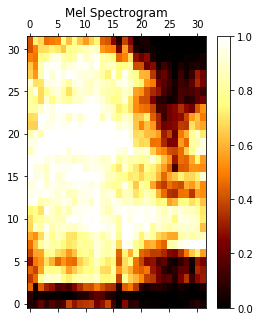

In [31]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(4,5))
cax = ax.matshow(x_train[100], interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Mel Spectrogram')

Text(0.5, 1.05, 'Mel Spectrogram')

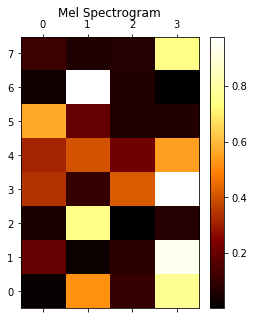

In [32]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(4,5))
cax = ax.matshow(enc_train_reshape[100], interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Mel Spectrogram')

In [33]:
resp_train = x_train1[:, 32:, :]
spec_train = [x.flatten() for x in x_train]
#enc_train

resp_test = x_val1[:, 32:, :]
spec_test = [x.flatten() for x in x_val]
#enc_test = enc_val
#x_val = x_val[:, :16, :]
#y_train = y_train[:, :16]
#y_val = y_val[:, :16]

In [34]:
np.shape(spec_train), np.shape(enc_train), np.shape(resp_train), np.shape(spec_test), np.shape(enc_val), np.shape(resp_test)

((51357, 1024),
 (51357, 32),
 (51357, 214, 32),
 (5706, 1024),
 (5706, 32),
 (5706, 214, 32))

In [35]:
np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/spec_train_{}.npy'.format(bird,d,d), spec_train)
np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/enc_train_{}.npy'.format(bird,d,d), enc_train)
np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/resp_train_{}.npy'.format(bird,d,d), resp_train)

np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/spec_test_{}.npy'.format(bird,d,d), spec_test)
np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/enc_test_{}.npy'.format(bird,d,d), enc_val)
np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/resp_test_{}.npy'.format(bird,d,d), resp_test)
        
np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/y_train_{}.npy'.format(bird,d,d), y_train)
np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/y_test_{}.npy'.format(bird,d,d), y_val)

np.save('/mnt/cube/srrudrar/tcm_model/{}/32x32/stim_resp_32x32_{}/pred_test_{}.npy'.format(bird,d,d), y_val)

In [ ]:
import json

In [ ]:
json.dump([float(i[0].numpy()) for i in test_losses],open('pred_only_64_channels_dropout_test_loss.json', 'w'))